## Prepare libraries and data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from textstat import sentence_count

In [2]:
from tabulate import tabulate
def latex_table(ds):
    print(tabulate(ds, ds.columns, tablefmt='latex'))

In [3]:
def d_metric(string):
    string_list = string.split()
    counts = np.unique(string_list, return_counts=True)[1]
    numerator = np.sum(counts*(counts-1))
    n = len(string_list)
    denominator = n*(n-1)
    return numerator/denominator

In [4]:
topwords = list(pd.read_csv('1-1000.txt', sep='~', header=None)[0])

In [5]:
def common_words(string):
    string_list = string.split()
    result = sum([word in topwords for word in string_list])
    return result

In [6]:
jokes = 'data/jokes/jokes4k.csv'

In [7]:
squad = 'data/squad/squad8k.csv'

In [8]:
tatman = 'data/tatman/tatman_bt.csv'

In [9]:
main_stats = ['CharacterNumber', 'WordNumber', 'CommonWordNumber', 'TTR', 'CTTR', 'DMetric', 'FRES', 'FKGL', 'ARI']
level_list = ["Knowledge", "Comprehension", "Application", "Analysis", "Synthesis", "Evaluation"]

# Histograms

In [10]:
def bt_histogram(f, title):
    plt.figure(figsize=(7, 2))
    ds = pd.read_csv(f, sep=';')
    ds.BT_Level.value_counts()[level_list].plot(kind='bar')
    plt.title(title)

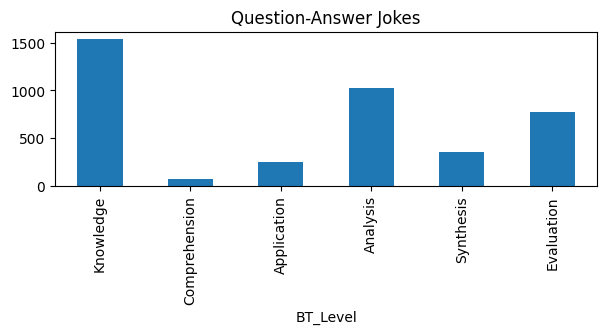

In [11]:
bt_histogram(jokes, "Question-Answer Jokes")

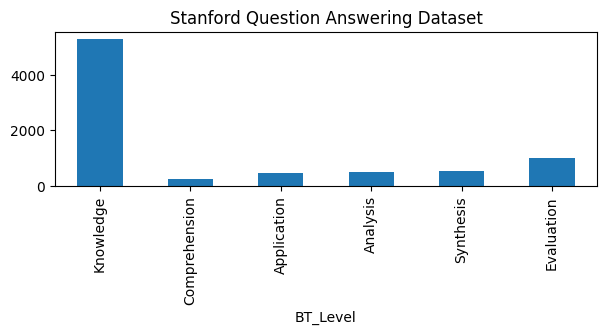

In [12]:
bt_histogram(squad, "Stanford Question Answering Dataset")

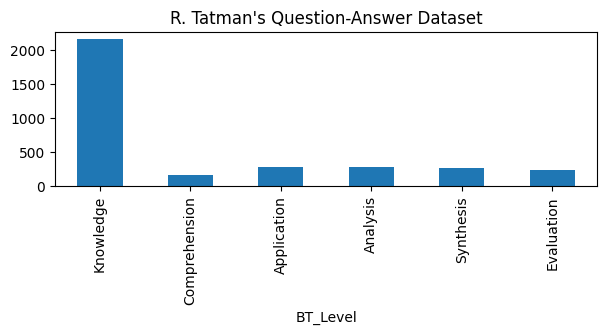

In [13]:
bt_histogram(tatman, "R. Tatman's Question-Answer Dataset")

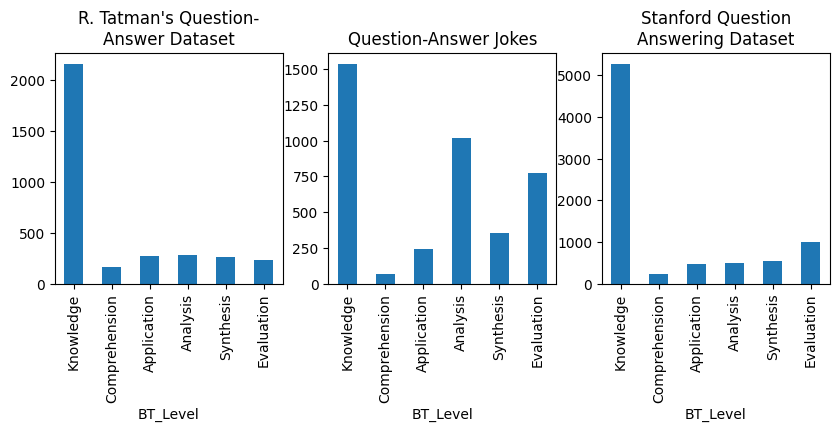

In [22]:
def bt_histogram_stacked():
    def bt_histogram_part(f, title, ax):
        ds = pd.read_csv(f, sep=';')
        ds.BT_Level.value_counts()[level_list].plot(kind='bar', ax=ax)
        ax.set_title(title)

    fig, axs = plt.subplots(1, 3, figsize=(10, 3))
    titles = ["R. Tatman's Question-\nAnswer Dataset", "Question-Answer Jokes", "Stanford Question\nAnswering Dataset"]
    bt_histogram_part(tatman, titles[0], axs[0])
    bt_histogram_part(jokes, titles[1], axs[1])
    bt_histogram_part(squad, titles[2], axs[2])

bt_histogram_stacked()

# Analysis tables

In [23]:
def sentence_analysis(ds):
    ds['CharacterNumber'] = ds.Question.str.len()
    ds['WordNumber'] = ds.Question.str.count(' ') + 1
    ds['CommonWordNumber'] = ds.Question.apply(common_words) / ds.WordNumber
    ds['UniqueWordNumber'] = ds.Question.str.split().apply(set).apply(len)
    ds['TTR'] = ds.UniqueWordNumber / ds.WordNumber
    ds['CTTR'] = ds.UniqueWordNumber / (ds.WordNumber*2)**0.5
    ds['DMetric'] = ds.Question.apply(d_metric)
    ds['SyllableNumber'] = ds.Question.str.count('(?!e$)[aeiouy]+') + ds.Question.str.count('^[^aeiouy]*e$')
    ds['SentenceNumber'] = ds.Question.apply(sentence_count)
    ds['MeanSentenceLength'] = ds.CharacterNumber/ds.SentenceNumber
    ds['FRES'] = 206.835 - 1.015 * ds.MeanSentenceLength - 84.6 * ds.SyllableNumber / ds.WordNumber
    ds['FKGL'] = 0.39 * ds.MeanSentenceLength + 11.8 * ds.SyllableNumber / ds.WordNumber - 15.59
    ds['ARI'] = 0.5 * ds.MeanSentenceLength + 47.1 * ds.CharacterNumber / ds.WordNumber - 21.34
    return ds

In [24]:
def statistics(f):
    ds = pd.read_csv(f, sep=';')
    
    dsa = sentence_analysis(ds)
    dsstats = dsa[main_stats+['BT_Level']]
    return dsstats

In [25]:
def combine(ds_levels, ds_overall):
    level_order = ["overall", "Knowledge", "Comprehension", "Application", "Analysis", "Synthesis", "Evaluation"]
    overall_row = ds_overall.to_frame().T
    stacked = pd.concat([overall_row, ds_levels])
    stacked.loc['overall'] = stacked.loc[0]
    return stacked.drop([0]).loc[level_order]

In [26]:
def value_stats(ds):    
    small_ds = ds[main_stats+['BT_Level']]
    grouped = small_ds.groupby('BT_Level')
    smaller_ds = small_ds[main_stats]
    means = combine(grouped.mean(), smaller_ds.mean())
    varis = combine(grouped.std(), smaller_ds.std())
    mins = combine(grouped.min(), smaller_ds.min())
    maxs = combine(grouped.max(), smaller_ds.max())
    return means, varis, mins, maxs

In [27]:
def meanvar(ds):
    vs = value_stats(statistics(ds))
    meanvar = vs[0]
    justvar = vs[1]
    for column in meanvar.columns:
        meanvar[column] = meanvar[column].map('{:,.2g}'.format) + " ± " + justvar[column].map('{:,.2g}'.format)
    return meanvar

In [28]:
def minmax(ds):
    vs = value_stats(statistics(ds))
    minmax = vs[2]
    justmax = vs[3]
    for column in minmax.columns:
        minmax[column] = minmax[column].map('{:,.2g}'.format) + " ÷ " + justmax[column].map('{:,.2g}'.format)
    return minmax

In [29]:
latex_table(meanvar(tatman).iloc[:, :6])
latex_table(meanvar(tatman).iloc[:, 6:])

\begin{tabular}{lllllll}
\hline
               & CharacterNumber   & WordNumber   & CommonWordNumber   & TTR          & CTTR       & DMetric         \\
\hline
 overall       & 52 ± 25           & 9.9 ± 4.5    & 0.49 ± 0.14        & 0.98 ± 0.052 & 2.1 ± 0.36 & 0.0044 ± 0.01   \\
 Knowledge     & 47 ± 19           & 9.1 ± 3.4    & 0.5 ± 0.14         & 0.98 ± 0.047 & 2 ± 0.3    & 0.0041 ± 0.0099 \\
 Comprehension & 65 ± 34           & 12 ± 6.5     & 0.44 ± 0.13        & 0.96 ± 0.067 & 2.3 ± 0.42 & 0.0059 ± 0.01   \\
 Application   & 56 ± 24           & 10 ± 4.2     & 0.47 ± 0.13        & 0.97 ± 0.052 & 2.2 ± 0.34 & 0.0049 ± 0.011  \\
 Analysis      & 64 ± 32           & 11 ± 5.6     & 0.48 ± 0.14        & 0.97 ± 0.058 & 2.3 ± 0.42 & 0.0039 ± 0.0089 \\
 Synthesis     & 59 ± 38           & 11 ± 6.8     & 0.49 ± 0.15        & 0.97 ± 0.06  & 2.2 ± 0.48 & 0.0056 ± 0.012  \\
 Evaluation    & 62 ± 31           & 12 ± 5.5     & 0.51 ± 0.13        & 0.97 ± 0.058 & 2.3 ± 0.41 & 0.0055 ± 0.013  \\
\

In [30]:
latex_table(minmax(tatman).iloc[:, :6])
latex_table(minmax(tatman).iloc[:, 6:])

\begin{tabular}{lllllll}
\hline
               & CharacterNumber   & WordNumber   & CommonWordNumber   & TTR      & CTTR      & DMetric   \\
\hline
 overall       & 15 ÷ 2.7e+02      & 4 ÷ 50       & 0 ÷ 0.89           & 0.65 ÷ 1 & 1.4 ÷ 4.1 & 0 ÷ 0.073 \\
 Knowledge     & 15 ÷ 1.9e+02      & 4 ÷ 37       & 0.091 ÷ 0.89       & 0.73 ÷ 1 & 1.4 ÷ 3.4 & 0 ÷ 0.073 \\
 Comprehension & 23 ÷ 2.7e+02      & 5 ÷ 44       & 0.1 ÷ 0.79         & 0.7 ÷ 1  & 1.6 ÷ 3.5 & 0 ÷ 0.038 \\
 Application   & 19 ÷ 2.1e+02      & 5 ÷ 37       & 0 ÷ 0.8            & 0.75 ÷ 1 & 1.4 ÷ 3.8 & 0 ÷ 0.071 \\
 Analysis      & 20 ÷ 2e+02        & 5 ÷ 38       & 0.1 ÷ 0.88         & 0.65 ÷ 1 & 1.6 ÷ 3.5 & 0 ÷ 0.048 \\
 Synthesis     & 21 ÷ 2.5e+02      & 4 ÷ 50       & 0.12 ÷ 0.89        & 0.71 ÷ 1 & 1.4 ÷ 4.1 & 0 ÷ 0.067 \\
 Evaluation    & 16 ÷ 2.2e+02      & 4 ÷ 42       & 0.14 ÷ 0.78        & 0.74 ÷ 1 & 1.4 ÷ 3.7 & 0 ÷ 0.071 \\
\hline
\end{tabular}
\begin{tabular}{llll}
\hline
               & FRES               & F

In [31]:
latex_table(meanvar(jokes).iloc[:, :6])
latex_table(meanvar(jokes).iloc[:, 6:])

\begin{tabular}{lllllll}
\hline
               & CharacterNumber   & WordNumber   & CommonWordNumber   & TTR          & CTTR       & DMetric         \\
\hline
 overall       & 48 ± 15           & 10 ± 2.9     & 0.6 ± 0.14         & 0.97 ± 0.054 & 2.2 ± 0.29 & 0.0057 ± 0.012  \\
 Knowledge     & 44 ± 14           & 9.4 ± 2.7    & 0.59 ± 0.15        & 0.97 ± 0.053 & 2.1 ± 0.29 & 0.0056 ± 0.012  \\
 Comprehension & 53 ± 14           & 11 ± 2.9     & 0.58 ± 0.13        & 0.98 ± 0.051 & 2.3 ± 0.28 & 0.0038 ± 0.0095 \\
 Application   & 52 ± 15           & 11 ± 2.9     & 0.58 ± 0.13        & 0.98 ± 0.047 & 2.3 ± 0.28 & 0.0042 ± 0.0094 \\
 Analysis      & 53 ± 14           & 11 ± 2.7     & 0.61 ± 0.13        & 0.96 ± 0.058 & 2.3 ± 0.25 & 0.0067 ± 0.012  \\
 Synthesis     & 51 ± 15           & 11 ± 3.2     & 0.61 ± 0.14        & 0.97 ± 0.057 & 2.3 ± 0.28 & 0.0057 ± 0.011  \\
 Evaluation    & 47 ± 15           & 10 ± 3       & 0.59 ± 0.14        & 0.97 ± 0.052 & 2.2 ± 0.29 & 0.0052 ± 0.013  \\
\

In [32]:
latex_table(minmax(jokes).iloc[:, :6])
latex_table(minmax(jokes).iloc[:, 6:])

\begin{tabular}{lllllll}
\hline
               & CharacterNumber   & WordNumber   & CommonWordNumber   & TTR      & CTTR      & DMetric   \\
\hline
 overall       & 9 ÷ 1e+02         & 2 ÷ 23       & 0 ÷ 0.94           & 0.41 ÷ 1 & 1 ÷ 3.2   & 0 ÷ 0.18  \\
 Knowledge     & 9 ÷ 1e+02         & 2 ÷ 21       & 0 ÷ 0.94           & 0.64 ÷ 1 & 1 ÷ 3.1   & 0 ÷ 0.076 \\
 Comprehension & 28 ÷ 91           & 5 ÷ 19       & 0.19 ÷ 0.83        & 0.72 ÷ 1 & 1.6 ÷ 2.9 & 0 ÷ 0.052 \\
 Application   & 18 ÷ 97           & 5 ÷ 23       & 0.14 ÷ 0.85        & 0.77 ÷ 1 & 1.4 ÷ 3   & 0 ÷ 0.067 \\
 Analysis      & 23 ÷ 1e+02        & 5 ÷ 22       & 0.059 ÷ 0.93       & 0.41 ÷ 1 & 1.2 ÷ 3.2 & 0 ÷ 0.16  \\
 Synthesis     & 24 ÷ 1e+02        & 5 ÷ 22       & 0.11 ÷ 0.93        & 0.57 ÷ 1 & 1.6 ÷ 3.2 & 0 ÷ 0.095 \\
 Evaluation    & 14 ÷ 1e+02        & 4 ÷ 23       & 0 ÷ 0.92           & 0.64 ÷ 1 & 1.4 ÷ 3.2 & 0 ÷ 0.18  \\
\hline
\end{tabular}
\begin{tabular}{llll}
\hline
               & FRES          & FKGL  

In [33]:
latex_table(meanvar(squad).iloc[:, :6])
latex_table(meanvar(squad).iloc[:, 6:])

\begin{tabular}{lllllll}
\hline
               & CharacterNumber   & WordNumber   & CommonWordNumber   & TTR          & CTTR       & DMetric         \\
\hline
 overall       & 60 ± 20           & 11 ± 3.5     & 0.54 ± 0.12        & 0.98 ± 0.045 & 2.3 ± 0.32 & 0.0039 ± 0.0081 \\
 Knowledge     & 56 ± 18           & 11 ± 3.2     & 0.54 ± 0.13        & 0.98 ± 0.043 & 2.2 ± 0.3  & 0.0037 ± 0.0082 \\
 Comprehension & 71 ± 22           & 13 ± 4.2     & 0.52 ± 0.11        & 0.97 ± 0.053 & 2.4 ± 0.32 & 0.0052 ± 0.0086 \\
 Application   & 68 ± 18           & 13 ± 3.2     & 0.53 ± 0.11        & 0.97 ± 0.047 & 2.4 ± 0.27 & 0.0043 ± 0.0082 \\
 Analysis      & 71 ± 22           & 13 ± 3.9     & 0.55 ± 0.12        & 0.97 ± 0.05  & 2.4 ± 0.33 & 0.0046 ± 0.0087 \\
 Synthesis     & 68 ± 21           & 13 ± 3.8     & 0.55 ± 0.12        & 0.98 ± 0.043 & 2.5 ± 0.32 & 0.0037 ± 0.007  \\
 Evaluation    & 68 ± 20           & 13 ± 3.6     & 0.54 ± 0.12        & 0.97 ± 0.048 & 2.4 ± 0.31 & 0.0044 ± 0.0078 \\
\

In [34]:
latex_table(minmax(squad).iloc[:, :6])
latex_table(minmax(squad).iloc[:, 6:])

\begin{tabular}{lllllll}
\hline
               & CharacterNumber   & WordNumber   & CommonWordNumber   & TTR      & CTTR      & DMetric   \\
\hline
 overall       & 14 ÷ 1.7e+02      & 4 ÷ 33       & 0.1 ÷ 0.92         & 0.67 ÷ 1 & 1.4 ÷ 3.8 & 0 ÷ 0.073 \\
 Knowledge     & 14 ÷ 1.6e+02      & 4 ÷ 28       & 0.1 ÷ 0.92         & 0.7 ÷ 1  & 1.4 ÷ 3.4 & 0 ÷ 0.073 \\
 Comprehension & 25 ÷ 1.7e+02      & 5 ÷ 33       & 0.15 ÷ 0.78        & 0.78 ÷ 1 & 1.6 ÷ 3.8 & 0 ÷ 0.038 \\
 Application   & 31 ÷ 1.4e+02      & 7 ÷ 25       & 0.18 ÷ 0.9         & 0.77 ÷ 1 & 1.8 ÷ 3.2 & 0 ÷ 0.055 \\
 Analysis      & 25 ÷ 1.5e+02      & 6 ÷ 25       & 0.12 ÷ 0.88        & 0.7 ÷ 1  & 1.7 ÷ 3.5 & 0 ÷ 0.058 \\
 Synthesis     & 29 ÷ 1.4e+02      & 6 ÷ 27       & 0.12 ÷ 0.92        & 0.67 ÷ 1 & 1.7 ÷ 3.4 & 0 ÷ 0.059 \\
 Evaluation    & 21 ÷ 1.4e+02      & 5 ÷ 28       & 0.14 ÷ 0.9         & 0.75 ÷ 1 & 1.6 ÷ 3.5 & 0 ÷ 0.045 \\
\hline
\end{tabular}
\begin{tabular}{llll}
\hline
               & FRES               & F

# Training history

In [35]:
history = pd.read_csv('history.csv', sep=',')

In [36]:
history

,Unnamed: 0,accuracy,f1_score,loss,val_accuracy,val_f1_score,val_loss
0,0,0.442926,tf.Tensor([0.28761056 0.30339316 0.600464 0....,1.478505,0.521739,tf.Tensor([0.33333328 0.42857137 0.63758385 0....,1.170493
1,1,0.661084,tf.Tensor([0.6008065 0.5510597 0.7533959 0....,0.956936,0.719368,tf.Tensor([0.7666666 0.6506024 0.79310334 0....,0.826815
2,2,0.765095,tf.Tensor([0.7554672 0.64963496 0.8166204 0....,0.701607,0.747036,tf.Tensor([0.7692307 0.74999994 0.8287293 0....,0.752559
3,3,0.835610,tf.Tensor([0.81467175 0.8115942 0.8686416 0....,0.510709,0.743083,tf.Tensor([0.7714285 0.70270264 0.7393939 0....,0.736872
4,4,0.897312,tf.Tensor([0.8945454 0.866785 0.91999996 0....,0.356636,0.707510,tf.Tensor([0.74999994 0.71698105 0.80213904 0....,0.767817
...,...,...,...,...,...,...,...
67,67,0.997356,tf.Tensor([0.9981718 0.99121267 0.9994222 0....,0.009092,0.822134,tf.Tensor([0.7924527 0.7671232 0.8539325 0....,1.222509
68,68,0.996915,tf.Tensor([1. 0.9964788 0.9976878 0....,0.007778,0.830040,tf.Tensor([0.8727272 0.8181817 0.8510637 0....,1.123869
69,69,0.997356,tf.Tensor([1. 0.9982425 0.9965317 0....,0.010386,0.814229,tf.Tensor([0.78571427 0.8059701 0.82901543 0....,1.146018
70,70,0.998678,tf.Tensor([1. 1. 0.9982669 1....,0.002859,0.806324,tf.Tensor([0.79310346 0.74999994 0.8526315 0....,1.110106


Text(0.5, 0, 'number of epochs')

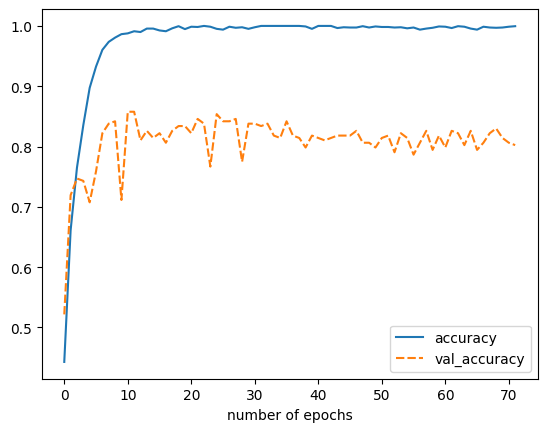

In [37]:
sns.lineplot(history[['accuracy', 'val_accuracy']])
plt.xlabel('number of epochs')

# Simple examples

tatman:
* what is a roo ?
* what is jakarta ?
* garbage is what ?
* when did he die ?
* what is antwerp ?
* what is the mrt ?
* what is santiago ?
* is egypt in asia ?
* are turtles pets ?
* is ghana in asia ?
* the sociolinguistic situation of arabic provides a prime example of what ?
* can the title of this famous 1811 paper be roughly translated into english as `` essay on determining the relative masses of the elementary molecules of bodies '' ?
* about how many square kilometers would be needed to house 3 female tigers ?
* why are harp guitars difficult to classify ?
* how is south china linguistically different from north china ?
* how does the distribution size of the leopard compare to the distribution of other wild cats ?
* what can be augmented with a fourth valve ?
* what cello manufacturer should i buy from if i want to play outside ?
* why polar bear is a special species ?
* what includes a lengthy justification of why this species is listed as vulnerable ?

squad:

* who is midna ?
* what are poes ?
* what is karma ?
* what is avidya ?
* what is dukkha ?
* who won the war ?
* who saves midna ?
* who is tadaklan ?
* what is samsara ?
* what does ren do ?
* dukkha can be translated as what word in regards to unhappiness ?
* dukkha is often translated as suffering , but the philosophical meaning of dukkha of more closely related to what term ?
* how high could the homeless number possibly go ?
* why should trees not be planted on the side of a building facing the equator ?
* what kind of features differentiate gray wolves from dogs ?
* how are they different than most tajiks ?
* what can a/v cables be used to connect the ipod to ?
* what can happen if people are exposed to antibiotics at a young age ?
* why is attachment to things futile ?
* why is a second meter usually unnecessary to monitor electricity use ?

jokes:

* what was 2016 ?
* what 's 11 & 2 ?
* why did 10 die ?
* what are sardines ?
* what is your name ?
* if an ant smells bad , what is it called ?
* what do bostonians call dogs that protect heaven 's gates ?
* what do you call a dwarf with a birth defect , is broke and can 't drink milk ?
* how do you get 100 ethiopians in a phone box ?
* how do you draw a scatter plot ?
* how do you make a tissue dance ?
* what 's the difference between pink and purple ?
* what 's the difference between canadian baseball and an old testament drug dealer ?
* what 's the difference between an irish wedding and an irish funeral ?
* what’s the best way to stop a runaway horse ?
* what is the best place to hide a dead body ?
* what 's the quickest way to a man 's heart ?
* why is it hard to watch two elephants boxing ?
* why is yoda the worst copilot ?
* why is the long term liability sad ?

In [38]:
def full_ds(ds, level):
    sa = sentence_analysis(pd.read_csv(ds, sep=';', index_col=0)).drop_duplicates(subset=['Question'])
    sa_level = sa[sa.BT_Level==level].sort_values(by='CharacterNumber')[['Question', 'BT_Level', 'CharacterNumber']]
    return sa_level

In [39]:
for q in full_ds(jokes, 'Knowledge').head(30).Question:
    print(q)

advices ?
9 /11 who ?
last rites ?
is sex work ?
boy or girl ?
wanna dance ?
bad weather ?
what is 6.9 ?
did you know ?
had ur lunch ?
what was 2016 ?
what 's 11 & 2 ?
does god exist ?
cash or credit ?
what is reddit ?
why did 10 die ?
what 's joke #1 ?
what time is it ?
are you russian ?
notice anything ?
what room is it ?
is your ass okay ?
what computer eat ?
what 's an allepo ?
what are sardines ?
what sounds funny ?
what is your name ?
wanna hear a joke ?
how did you sleep ?
what is bluetooth ?


In [40]:
for q in full_ds(jokes, 'Comprehension').Question:
    if 'call' in q:
        print(q)

what do you call the queue to alcatraz ?
if an ant smells bad , what is it called ?
what do you call chips that aren 't yours ?
what do you call idubbbz when he is angry ?
what would you call a rock digger 's mistake ?
what do you call the study of japanese sound ?
what do you call a samsung 7 user taking a selfie ?
what do you call weed grown in a ceramic container ?
what do bostonians call dogs that protect heaven 's gates ?
what do you call it when someone from belarus lies to you ?
what do you call muslims at the end of their religious service ?
what would hitler call an educational program for young germans ?
what do you call ill-mannered burst of strong wind in the desert ?
what do you call it when usain bolt is standing next to your mom ?
what do you call the moisture build-up between two cousins having sex ?
what do you call your favorite 80 's pop star floating dead in the harbor ?
what do you call a dwarf with a birth defect , is broke and can 't drink milk ?
why do people ca

In [41]:
for q in full_ds(jokes, 'Application').Question:
    if 'how ' in q:
        print(q)

how do bovines do math ?
how does greenland win a war ?
how does a grizzly catch fish ?
how do you make a tissue dance ?
how do you draw a scatter plot ?
how i get my dick to be 12 inches ?
how do you get over trump 's wall ?
how do you write poop in australia ?
asked a hen how many eggs it lays daily ?
how do we know paul walker had dandruff ?
how is making cheese like invading syria ?
how do you get jizz off of a scrabble board ?
how does winnie the pooh open his honey pot ?
how does a ethiopian show that they are rich ?
how do you get 100 ethiopians in a phone box ?
how will donald trump create 25 millions jobs ?
hey , you know how geese migrate in a v shape ?
how do men in new zealand address their women ?
how does harry potter like his sandwiches to be cut ?
how do they pick kids for the make-a-wish foundation ?
how does a paralympian call home , after winning a medal ?
how did george michael speak when he couldn 't eat fruit ?
why doesn 't lilly from at &t commercials show any cl

In [42]:
for q in full_ds(jokes, 'Analysis').Question:
    if 'differ' in q:
        print(q)

what is the difference between a duck ?
what 's the difference between a duck ?
what 's the difference between op and eggs ?
what 's the difference between you and eggs ?
what 's the difference between anal and oral ?
what is the difference between jam and jelly ?
whats the difference between a jew and santa ?
what 's the difference between jam and jelly ?
what 's the difference between jelly and jam ?
what 's the difference between purple and pink ?
what 's the difference between turkey and duck ?
whats the difference between a cat and a comma ?
what is the difference between a dog and a cat ?
what 's the difference between pink and purple ?
what is the difference between a bmw and a cow ?
whats the difference between a usb and the usa ?
what 's the difference between 9 /11 and a cow ?
what 's the difference between a cow and 9 /11 ?
what 's the difference between a doctor and god ?
what 's the difference between hitler and trump ?
what 's the difference between erotic and kinky ?
wha

In [43]:
for q in full_ds(jokes, 'Synthesis').Question:
    print(q)

would you pass the tea ?
is this inkjet any good ?
what does a new pilot do ?
what joke never gets old ?
why did hitler take xanax ?
what do i put in mecoffee ?
son : mom , how was i born ?
can vegetarians eat pudding ?
what did mars say to saturn ?
wanna hear a terrorist joke ?
how do you make a dog drink ?
why did the coach go to aldi ?
why did the flower fall over ?
can a human outrun a cheetah ?
how to you piss off a writer ?
what 's your opinion on birds ?
why could jesus walk on water ?
how do you get a fire started ?
how do you get a nun pregnant ?
what has two wings and a halo ?
what 's your view on lesbians ?
want to hear a joke about udp ?
what has 4 legs but cant move ?
why was peter pan a bad boxer ?
survey gone wrong.. or right ? ?
man : hi , do you want to dance ?
how do you lower the crime rate ?
how do you catch a unique bunny ?
why did the ghost go into rehab ?
how do crabs leave the hospital ?
how do you pick up a jewish girl ?
who wears a toga and a face mask ?
why d

In [44]:
for level in level_list:
    levelq = list(full_ds(jokes, level).Question) + list(full_ds(tatman, level).Question) + list(full_ds(squad, level).Question)
    print(len([q for q in levelq if 'why ' in q]))

260
28
127
151
51
331
